# Environment setup
The following code can help you install the packages required for the pyspark environment in Colab

In [ ]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317124 sha256=7a2ba0f1f1ac068dee85e9cfc2b828d81bc88c6cbbf572585a8da7c8b0f86ec8
  Stored in directory: /root/.cache/pip/wheels/7f/71/c8/6ffadf411f7456a87d125cf3b7735f091f24e56ba54dd17852
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.4.0 which is incompatible.


The following is to mount Google drive files

In [2]:
# View and modify the working path
import os
from google.colab import drive


# View current working directory
print("Current Working Directory:", os.getcwd())

# Mount Google Drive
drive.mount('/content/drive')

# Change working directory to your file position
path = "/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/data"
os.chdir(path)

# Confirm the change
print("Working Directory:", os.getcwd())

Current Working Directory: /content
Mounted at /content/drive
Working Directory: /content/drive/MyDrive/bdh-hw2-pyspark-publish_colab/data


Create the test scoring

In [9]:
import pandas as pd

def create_initial_score_df():
    # Test names
    test_names = ['TestEventStatistics', 'ETLTest']
    # Initial scores set to 0
    initial_scores = [0, 0]
    # Creating the DataFrame
    df = pd.DataFrame({'Test': test_names, 'Score': initial_scores})
    return df

# Create the initial DataFrame
df_score = create_initial_score_df()

# 2.1 Descriptive Statistics [15 points]

In [10]:
from ast import alias
import pyspark
import time
import pip
import pandas as pd
import numpy as np
import random
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import datediff, to_date, max as max_, lit, col, collect_list, row_number, concat_ws, format_number, concat, monotonically_increasing_id
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

def read_csv(spark, file, schema):
    return spark.read.csv(file, header=False, schema=schema)

def split_alive_dead(events, mortality):
    '''
    param: spart dataframe events: [petientid, eventid, etimestamp, value] and dataframe mortality: [patientid, mtimestamp, label]
    return: spark dataframe alive_evnets and dead_events

    Task1: This function needs to be completed.
    Split the events to two spark dataframes. One is for alive patients, and one is
    for dead patients.
    Variables returned from this function are passed as input DataFrame for later.
    '''
    dead_ids=mortality.select('patientid').distinct()
    dead_events=events.join(dead_ids,on='patientid',how='inner')
    alive_events=events.join(dead_ids,on='patientid',how='left_anti')


    #alive_events, dead_events = events, events

    return alive_events, dead_events

def event_count_metrics(alive_events, dead_events):
    '''
    param: two spark DataFrame: alive_events, dead_events
    return: two spark DataFrame

    Task 2: Event count metrics
    Compute average, min and max of event counts
    for alive and dead patients respectively
    +------+------+------+
    |   avg|   min|  max |
    +------+------+------+
    |value1|value2|value3|
    +------+------+------+
    note:
    1.please keep same column name as example showed before!
    2.return two DataFrame for alive and dead patients' events respectively.
    3.average computed with avg(), DO NOT round the results.
    '''

    data = [(0.0, 0.0, 0.0)]
    columns = ["avg", "min", "max"]
    alive_statistics = spark.createDataFrame(data=data, schema=columns)
    dead_statistics = spark.createDataFrame(data=data, schema=columns)

    def stats(df):
        per_patient=df.groupBy('patientid').count()
        return per_patient.agg(avg('count').alias('avg'),
                         min('count').alias('min'),
                         max('count').alias('max'))
    alive_statistics=stats(alive_events)
    dead_statistics=stats(dead_events)

    return alive_statistics, dead_statistics

def encounter_count_metrics(alive_events, dead_events):
    '''
    param: two spark DataFrame: alive_events, dead_events
    return: two spark DataFrame

    Task3: Compute average, median, min and max of encounter counts
    for alive and dead patients respectively
    +------+--------+------+------+
    |  avg | median | min  | max  |
    +------+--------+------+------+
    |value1| value2 |value3|value4|
    +------+--------+------+------+
    note:
    1.keep alive dataframe and dead dateframe respectively, in this case, you will get 2 (1 for alive and 1 for dead) dataframe.
    2.please keep same column name as example showed before!
    3.average computed with mean(), DO NOT need to round the results.
    4.for the median section, when the array is even, do not use the average of the two middle elements, you can choose
      the smallest value around the midpoint of an even array. Or, 'percentile_approx' func may useful, the link:
      https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.functions.percentile_approx.html.

    '''
    def stats(df):
      per_patient=(df.withColumn('ecday',col('etimestamp')).groupBy('patientid').agg(countDistinct('ecday').alias('enc_count')))
      return per_patient.agg(mean('enc_count').alias('avg'),
             percentile_approx('enc_count',0.5).alias('median'),
             min('enc_count').alias('min'), max('enc_count').alias('max'))

    data = [(0.0, 0.0, 0.0, 0.0)]
    columns = ["avg", "median", "min", "max"]
    alive_encounter_res = spark.createDataFrame(data=data, schema=columns)
    dead_encounter_res= spark.createDataFrame(data=data, schema=columns)

    alive_encounter_res=stats(alive_events)
    dead_encounter_res=stats(dead_events)
    return alive_encounter_res, dead_encounter_res

def record_length_metrics(alive_events, dead_events):
    '''
    param: two spark DataFrame:alive_events, dead_events
    return: two spark DataFrame

    Task4: Record length metrics
    Compute average, median, min and max of record lengths
    for alive and dead patients respectively
    +------+--------+------+------+
    |  avg | median | min  | max  |
    +------+--------+------+------+
    |value1| value2 |value3|value4|
    +------+--------+------+------+
    note:
    1.keep alive dataframe and dead dateframe respectively, in this case, you will get 2 (1 for alive and 1 for dead) dataframe.
    2.please keep same column name as example showed before!
    3.average computed with mean(), DO NOT round the results.

    '''
    data = [(0.0, 0.0, 0.0, 0.0)]
    columns = ["avg", "median", "min", "max"]
    alive_recordlength_res = spark.createDataFrame(data=data, schema=columns)
    dead_recordlength_res = spark.createDataFrame(data=data, schema=columns)


    def stats(df):
      per_patient=(df.groupBy('patientid').agg(min('etimestamp').alias('minday'), max('etimestamp').alias('maxday'))
                                          .withColumn('reclen',datediff(col('maxday'),col('minday'))))
      return per_patient.agg(
          mean('reclen').alias('avg'),
          percentile_approx('reclen',0.5).alias('median'),
          min('reclen').alias('min'),
          max('reclen').alias('max'))
    alive_recordlength_res=stats(alive_events)
    dead_recordlength_res=stats(dead_events)

    return alive_recordlength_res, dead_recordlength_res

def Common(alive_events, dead_events):
    '''
    param: two spark DataFrame: alive_events, dead_events
    return: six spark DataFrame
    Task 5: Common diag/lab/med
    Compute the 5 most frequently occurring diag/lab/med
    for alive and dead patients respectively
    +------------+----------+
    |   eventid  |diag_count|
    +------------+----------+
    |  DIAG999999|      9999|
    |  DIAG999999|      9999|
    |  DIAG999999|      9999|
    |  DIAG999999|      9999|
    |  DIAG999999|      9999|
    +------------+----------+

    +------------+----------+
    |   eventid  | lab_count|
    +------------+----------+
    |  LAB999999 |      9999|
    |  LAB999999 |      9999|
    |  LAB999999 |      9999|
    |  LAB999999 |      9999|
    +------------+----------+

    +------------+----------+
    |   eventid  | med_count|
    +------------+----------+
    |  DRUG999999|      9999|
    |  DRUG999999|      9999|
    |  DRUG999999|      9999|
    |  DRUG999999|      9999|
    |  DRUG999999|      9999|
    +------------+----------+
    note:
    1.keep alive dataframe and dead dateframe respectively, in this case, you will get 6 (3 for alive and 3 for dead) dataframe.
    2.please keep same column name as example showed before!
    '''
    data = [("DIAG999999", 999),("DIAG999999", 999),("DIAG999999", 999),("DIAG999999", 999),("DIAG999999", 999)]
    columns = ["eventid", "diag_count"]
    alive_diag= spark.createDataFrame(data=data, schema=columns)
    dead_diag= spark.createDataFrame(data=data, schema=columns)

    data = [("LAB999999", 999),("LAB999999", 999),("LAB999999", 999),("LAB999999", 999),("LAB999999", 999)]
    columns = ["eventid", "lab_count"]
    alive_lab= spark.createDataFrame(data=data, schema=columns)
    dead_lab= spark.createDataFrame(data=data, schema=columns)

    data = [("DRUG999999", 999),("DRUG999999", 999),("DRUG999999", 999),("DRUG999999", 999),("DRUG999999", 999)]
    columns = ["eventid", "med_count"]
    alive_med= spark.createDataFrame(data=data, schema=columns)
    dead_med= spark.createDataFrame(data=data, schema=columns)


    def tospk(df,prefix,count_name):
      return (df.where(col('eventid').startswith(prefix)).groupBy('eventid').count()
                                                          .withColumnRenamed('count',count_name)
                                                          .orderBy(col(count_name).desc(),col('eventid').asc()).limit(5))

    alive_diag=tospk(alive_events,"DIAG","diag_count")
    alive_lab=tospk(alive_events,"LAB","lab_count")
    alive_med=tospk(alive_events,"DRUG","med_count")

    dead_diag=tospk(dead_events,"DIAG","diag_count")
    dead_lab=tospk(dead_events,"LAB","lab_count")
    dead_med=tospk(dead_events,"DRUG","med_count")

    return alive_diag, alive_lab, alive_med, dead_diag, dead_lab, dead_med

def main():
    '''
    DO NOT MODIFY THIS FUNCTION.
    '''

    # You may change the following path variable in coding but switch it back when submission.
    path1 = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/data/events.csv'
    path2 = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/data/mortality.csv'

    schema1 = StructType([
        StructField("patientid", IntegerType(), True),
        StructField("eventid", StringType(), True),
        StructField("eventdesc", StringType(), True),
        StructField("timestamp", StringType(), True),
        StructField("value", FloatType(), True)])

    schema2 = StructType([
        StructField("patientid", IntegerType(), True),
        StructField("timestamp", StringType(), True),
        StructField("label", IntegerType(), True)])

    events = read_csv(spark, path1, schema1)
    events = events.select(events.patientid, events.eventid, to_date(events.timestamp).alias("etimestamp"), events.value)

    mortality = read_csv(spark, path2, schema2)
    mortality = mortality.select(mortality.patientid, to_date(mortality.timestamp).alias("mtimestamp"), mortality.label)

    alive_events, dead_events = split_alive_dead(events, mortality)

    #Compute the event count metrics
    start_time = time.time()
    alive_statistics, dead_statistics = event_count_metrics(alive_events, dead_events)
    end_time = time.time()
    print(("Time to compute event count metrics: " + str(end_time - start_time) + "s"))
    alive_statistics.show()
    dead_statistics.show()

    #Compute the encounter count metrics
    start_time = time.time()
    alive_encounter_res, dead_encounter_res = encounter_count_metrics(alive_events, dead_events)
    end_time = time.time()
    print(("Time to compute encounter count metrics: " + str(end_time - start_time) + "s"))
    alive_encounter_res.show()
    dead_encounter_res.show()

    #Compute record length metrics
    start_time = time.time()
    alive_recordlength_res, dead_recordlength_res = record_length_metrics(alive_events, dead_events)
    end_time = time.time()
    print(("Time to compute record length metrics: " + str(end_time - start_time) + "s"))
    alive_recordlength_res.show()
    dead_recordlength_res.show()

    #Compute Common metrics
    start_time = time.time()
    alive_diag, alive_lab, alive_med, dead_diag, dead_lab, dead_med = Common(alive_events, dead_events)
    end_time = time.time()
    print(("Time to compute event count metrics: " + str(end_time - start_time) + "s"))
    alive_diag.show()
    alive_lab.show()
    alive_med.show()
    dead_diag.show()
    dead_lab.show()
    dead_med.show()

if __name__ == "__main__":
    main()

Time to compute event count metrics: 0.2067556381225586s
+-----------------+---+-----+
|              avg|min|  max|
+-----------------+---+-----+
|683.1552587646077|  1|12627|
+-----------------+---+-----+

+------------------+---+-----+
|               avg|min|  max|
+------------------+---+-----+
|1027.7385229540919|  2|16829|
+------------------+---+-----+

Time to compute encounter count metrics: 0.24134230613708496s
+------------------+------+---+---+
|               avg|median|min|max|
+------------------+------+---+---+
|18.695492487479132|     9|  1|391|
+------------------+------+---+---+

+------------------+------+---+---+
|               avg|median|min|max|
+------------------+------+---+---+
|24.839321357285428|    14|  1|375|
+------------------+------+---+---+

Time to compute record length metrics: 0.3727717399597168s
+------------------+------+---+----+
|               avg|median|min| max|
+------------------+------+---+----+
|194.70283806343906|    16|  0|3103|
+----

#### Run this block to get the descriptive statistics test result

In [11]:
import unittest
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType

class TestEventStatistics(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        cls.spark = SparkSession.builder.appName('Test Event Statistics').getOrCreate()

        # You may change the following path variable in coding but switch it back when submission
        cls.path1 = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/sample_test/sample_events.csv'
        cls.path2 = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/sample_test/sample_mortality.csv'

        cls.schema1 = StructType([
            StructField("patientid", IntegerType(), True),
            StructField("eventid", StringType(), True),
            StructField("eventdesc", StringType(), True),
            StructField("timestamp", StringType(), True),
            StructField("value", FloatType(), True)
        ])

        cls.schema2 = StructType([
            StructField("patientid", IntegerType(), True),
            StructField("timestamp", StringType(), True),
            StructField("label", IntegerType(), True)
        ])

        cls.events = read_csv(cls.spark, cls.path1, cls.schema1)
        cls.events = cls.events.select(cls.events.patientid, cls.events.eventid, to_date(cls.events.timestamp).alias("etimestamp"), cls.events.value)

        cls.mortality = read_csv(cls.spark, cls.path2, cls.schema2)
        cls.mortality = cls.mortality.select(cls.mortality.patientid, to_date(cls.mortality.timestamp).alias("mtimestamp"), cls.mortality.label)

        cls.alive_events, cls.dead_events = split_alive_dead(cls.events, cls.mortality)
        cls.score = 0  # Initialize the score

    def test_event_count(self):
        try:
            actual_value_1 = 426.5
            actual_value_2 = 299
            actual_value_3 = 554
            actual_value_4 = 636.66666666
            actual_value_5 = 543
            actual_value_6 = 812

            alive_statistics, dead_statistics = event_count_metrics(self.alive_events, self.dead_events)

            avg_alive = alive_statistics.select('avg').collect()[0][0]
            min_alive = alive_statistics.select('min').collect()[0][0]
            max_alive = alive_statistics.select('max').collect()[0][0]
            avg_dead = dead_statistics.select('avg').collect()[0][0]
            min_dead = dead_statistics.select('min').collect()[0][0]
            max_dead = dead_statistics.select('max').collect()[0][0]

            self.assertAlmostEqual(avg_alive, actual_value_1, places=2, msg="UNEQUAL in live_avg, Expected:%s, Actual:%s" % (actual_value_1, avg_alive))
            self.assertAlmostEqual(min_alive, actual_value_2, places=2, msg="UNEQUAL in live_min, Expected:%s, Actual:%s" % (actual_value_2, min_alive))
            self.assertAlmostEqual(max_alive, actual_value_3, places=2, msg="UNEQUAL in live_max, Expected:%s, Actual:%s" % (actual_value_3, max_alive))
            self.assertAlmostEqual(avg_dead, actual_value_4, places=2, msg="UNEQUAL in dead_avg, Expected:%s, Actual:%s" % (actual_value_4, avg_dead))
            self.assertAlmostEqual(min_dead, actual_value_5, places=2, msg="UNEQUAL in dead_min, Expected:%s, Actual:%s" % (actual_value_5, min_dead))
            self.assertAlmostEqual(max_dead, actual_value_6, places=2, msg="UNEQUAL in dead_max, Expected:%s, Actual:%s" % (actual_value_6, max_dead))
            TestEventStatistics.score += 3  # Increment score
        except AssertionError:
            pass

    def test_encounter_count(self):
        try:
            expected_value_1 = 19.0
            expected_value_2 = 7
            expected_value_3 = 7
            expected_value_4 = 31
            expected_value_5 = 15.0
            expected_value_6 = 11
            expected_value_7 = 11
            expected_value_8 = 23

            alive_encounter_res, dead_encounter_res = encounter_count_metrics(self.alive_events, self.dead_events)

            avg_alive_encounter_count = alive_encounter_res.select('avg').collect()[0][0]
            median_alive_encounter_count = alive_encounter_res.select('median').collect()[0][0]
            min_alive_encounter_count = alive_encounter_res.select('min').collect()[0][0]
            max_alive_encounter_count = alive_encounter_res.select('max').collect()[0][0]
            avg_dead_encounter_count = dead_encounter_res.select('avg').collect()[0][0]
            median_dead_encounter_count = dead_encounter_res.select('median').collect()[0][0]
            min_dead_encounter_count = dead_encounter_res.select('min').collect()[0][0]
            max_dead_encounter_count = dead_encounter_res.select('max').collect()[0][0]

            self.assertAlmostEqual(avg_alive_encounter_count, expected_value_1, places=2)
            self.assertAlmostEqual(median_alive_encounter_count, expected_value_2, places=2)
            self.assertAlmostEqual(min_alive_encounter_count, expected_value_3, places=2)
            self.assertAlmostEqual(max_alive_encounter_count, expected_value_4, places=2)
            self.assertAlmostEqual(avg_dead_encounter_count, expected_value_5, places=2)
            self.assertAlmostEqual(median_dead_encounter_count, expected_value_6, places=2)
            self.assertAlmostEqual(min_dead_encounter_count, expected_value_7, places=2)
            self.assertAlmostEqual(max_dead_encounter_count, expected_value_8, places=2)
            TestEventStatistics.score += 3  # Increment score
        except AssertionError:
            pass

    def test_record_length(self):
        try:
            expected_value_1 = 1061.0
            expected_value_2 = 6
            expected_value_3 = 6
            expected_value_4 = 2116
            expected_value_5 = 25.66666666
            expected_value_6 = 21
            expected_value_7 = 10
            expected_value_8 = 46

            alive_recordlength_res, dead_recordlength_res = record_length_metrics(self.alive_events, self.dead_events)

            avg_alive_rec_len = alive_recordlength_res.select('avg').collect()[0][0]
            median_alive_rec_len = alive_recordlength_res.select('median').collect()[0][0]
            min_alive_rec_len = alive_recordlength_res.select('min').collect()[0][0]
            max_alive_rec_len = alive_recordlength_res.select('max').collect()[0][0]
            avg_dead_rec_len = dead_recordlength_res.select('avg').collect()[0][0]
            median_dead_rec_len = dead_recordlength_res.select('median').collect()[0][0]
            min_dead_rec_len = dead_recordlength_res.select('min').collect()[0][0]
            max_dead_rec_len = dead_recordlength_res.select('max').collect()[0][0]

            self.assertAlmostEqual(avg_alive_rec_len, expected_value_1, places=2)
            self.assertAlmostEqual(median_alive_rec_len, expected_value_2, places=2)
            self.assertAlmostEqual(min_alive_rec_len, expected_value_3, places=2)
            self.assertAlmostEqual(max_alive_rec_len, expected_value_4, places=2)
            self.assertAlmostEqual(avg_dead_rec_len, expected_value_5, places=2)
            self.assertAlmostEqual(median_dead_rec_len, expected_value_6, places=2)
            self.assertAlmostEqual(min_dead_rec_len, expected_value_7, places=2)
            self.assertAlmostEqual(max_dead_rec_len, expected_value_8, places=2)
            TestEventStatistics.score += 3  # Increment score
        except AssertionError:
            pass

    def test_Common(self):
        try:
            expected_value_1 = 1
            expected_value_2 = 3013682
            expected_value_3 = 4
            expected_value_4 = 2
            expected_value_5 = 55
            expected_value_6 = 956874

            alive_diag, alive_lab, alive_med, dead_diag, dead_lab, dead_med = Common(self.alive_events, self.dead_events)

            alive_diag_count = alive_diag.collect()[1][1]
            alive_event_id = alive_lab.collect()[2][0][3:]
            alive_med_count = alive_med.collect()[3][1]
            dead_event_id = dead_diag.collect()[0][1]
            dead_lab_count = dead_lab.collect()[4][1]
            dead_med_count = dead_med.collect()[0][0][4:]

            self.assertAlmostEqual(expected_value_1, alive_diag_count, places=2)
            self.assertAlmostEqual(expected_value_2, int(alive_event_id), places=2)
            self.assertAlmostEqual(expected_value_3, alive_med_count, places=2)
            self.assertAlmostEqual(expected_value_4, dead_event_id, places=2)
            self.assertAlmostEqual(expected_value_5, dead_lab_count, places=2)
            self.assertAlmostEqual(expected_value_6, int(dead_med_count), places=2)
            TestEventStatistics.score += 6  # Increment score
        except AssertionError:
            pass

    @classmethod
    def tearDownClass(cls):
        cls.spark.stop()
        if cls.score == 15:  # All tests passed
            print(f"All tests passed! Total Score: {cls.score}/15")
        else:
            print(f"Total Score: {cls.score}/15")

if __name__ == '__main__':
    # Create a test suite
    suite = unittest.TestLoader().loadTestsFromTestCase(TestEventStatistics)

    # Run the test suite
    unittest.TextTestRunner().run(suite)
    df_score.loc[df_score['Test'] == 'TestEventStatistics', 'Score'] = TestEventStatistics.score


....
----------------------------------------------------------------------
Ran 4 tests in 15.718s

OK


All tests passed! Total Score: 15/15


# 2.2 Transform data [28 points]

In [14]:
import random
import shutil
import os
import operator
import pyspark.sql.functions as F
from pyspark.sql.functions import datediff, to_date, max as max_, lit, col, collect_list, row_number, concat_ws, format_number, concat, monotonically_increasing_id
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
from pyspark.sql.window import Window

spark = SparkSession.builder.appName('Read CSV File into DataFrame').getOrCreate()
sc = spark.sparkContext

def read_csv(spark, file, schema):
    return spark.read.csv(file, header=False, schema=schema)

def calculate_index_dates(events, mortality):
    '''
    INPUT1:
    events_df read from events.csv
    e.g.
    +---------+------------+----------+-----+
    |patientid|     eventid|etimestamp|value|
    +---------+------------+----------+-----+
    |    20459|DIAG42872402|1994-12-04|  1.0|

    INPUT2:
    mortality_df read from mortality.csv
    +---------+----------+-----+
    |patientid|mtimestamp|label|
    +---------+----------+-----+
    |    13905|2000-01-30|    1|

    OUTPUT:
    index_df
    index_date is datetime.date format
    e.g.
    +---------+----------+
    |patientid|index_date|
    +---------+----------+
    |    20459|2000-09-19|
    |    13905|1999-12-31|
    +---------+----------+
    '''
    # The output coloumns should have the name (patientid, index_date)
    if False:
        index_dates = [(20459, '2000-09-19'),
          (5206, '2000-08-04')]
        columns = ["patientid", "index_date"]
        df = spark.createDataFrame(data=index_dates, schema=columns)
        return df

    deceased=(mortality.select('patientid',F.date_sub(F.col('mtimestamp'),30).alias('index_date')))
    final_event=(events.groupBy('patientid').agg(F.max('etimestamp').alias('index_date')))
    alive=(final_event.join(mortality.select('patientid').withColumnRenamed('patientid','dead_id'),
                            final_event.patientid==F.col('dead_id'),'left_anti').select('patientid','index_date'))

    return deceased.unionByName(alive)



def filter_events(events, index_dates):
    # TODO: filtered events should have the same input column of original events, select the corresponding columns and revise test as well
    '''
    INPUT:
    events: created events df, e.g.
    +---------+------------+----------+-----+
    |patientid|     eventid|etimestamp|value|
    +---------+------------+----------+-----+
    |    20459|DIAG42872402|1994-12-04|  1.0|
    +---------+------------+----------+-----+

    index_dates: created index_date df, e.g
    +---------+----------+
    |patientid|index_date|
    +---------+----------+
    |    20459|2000-09-19|
    +---------+----------+

    OUTPUT:
    filtered: e.g.
    +---------+--------------+----------+-----+
    |patientid|   eventid    |etimestamp|value|
    +---------+--------------+----------+-----+
    |    20459|'DIAG42872404'|1999-12-04|  1.0|
    |    19992|'DIAG42872403'|1995-12-04|  1.0|
    +---------+--------------+----------+-----+
    '''
    # Remove the events that are not in the observation window
    if False:

        filtered = [(20459, 'DIAG42872404', '1999-12-04', 1.0)]
        columns = ["patientid", "eventid", "etimestamp", "value"]
        df = spark.createDataFrame(data=filtered, schema=columns)
        return df

    j=events.join(index_dates,'patientid','inner')
    start_window=F.date_sub(F.col('index_date'),2000)

    return (j.where(F.col('etimestamp').between(start_window,F.col('index_date')))).select('patientid','eventid','etimestamp','value')

def aggregate_events(filtered):
    '''
    INPUT:
    filtered
    e.g.
    +---------+----------+----------+-----+
    |patientid|   eventid|etimestamp|value|
    +---------+----------+----------+-----+
    |    20459|LAB3013603|2000-09-19|  0.6|

    OUTPUT:
    patient_features
    e.g.
    +---------+------------+-------------+
    |patientid|     eventid|feature_value|
    +---------+------------+-------------+
    |     5206|DRUG19065818|            1|
    |     5206|  LAB3021119|            1|
    |    20459|  LAB3013682|           11|
    +---------+------------+-------------+
    '''
    # Output columns should be (patientid, eventid, feature_value)

    if False:
        features = [(20459, 'LAB3013682', 11)]
        columns = ["patientid", "eventid", "feature_value"]
        df = spark.createDataFrame(data=features, schema=columns)
        return df

    keep=filtered.where(F.col('eventid').startswith('DIAG')| F.col('eventid').startswith('DRUG')| F.col('eventid').startswith('LAB'))

    return (keep.groupBy('patientid','eventid').agg(F.count(F.lit(1)).alias('feature_value')))

def generate_feature_mapping(agg_events):
    '''
    INPUT:
    agg_events
    e.g.
    +---------+------------+-------------+
    |patientid|     eventid|feature_value|
    +---------+------------+-------------+
    |     5206|DRUG19065818|            1|
    |     5206|  LAB3021119|            1|
    |    20459|  LAB3013682|           11|
    +---------+------------+-------------+

    OUTPUT:
    event_map
    e.g.
    +----------+-----------+
    |   eventid|event_index|
    +----------+-----------+
    |DIAG132797|          0|
    |DIAG135214|          1|
    |DIAG137829|          2|
    |DIAG141499|          3|
    |DIAG192767|          4|
    |DIAG193598|          5|
    +----------+-----------+
    '''
    # Hint: pyspark.sql.functions: monotonically_increasing_id
    # Output colomns should be (eventid, event_index)

    if False:
        event_map = [("DIAG132797", 0)]
        columns = ["eventid", "event_index"]
        df = spark.createDataFrame(data=event_map, schema=columns)
        return df

    win=Window.orderBy(F.col('eventid').asc())
    return (agg_events.select('eventid').distinct().withColumn('event_index',F.row_number().over(win)-F.lit(0)-1).withColumn('event_index',F.col('event_index').cast('int')))

def normalization(agg_events):
    '''
    INPUT:
    agg_events
    e.g.
    +---------+------------+-------------+
    |patientid|     eventid|feature_value|
    +---------+------------+-------------+
    |     5206|DRUG19065818|            1|
    |     5206|  LAB3021119|            1|
    |    20459|  LAB3013682|           11|


    OUTPUT:
    normalized
    e.g.
    +---------+------------+------------------------+
    |patientid|     eventid|normalized_feature_value|
    +---------+------------+------------------------+
    |     5206|DRUG19065818|                   1.000|
    |     5206|  LAB3021119|                   1.000|
    |    20459|  LAB3013682|                   0.379|
    +---------+------------+------------------------+
    '''
    # Output columns should be (patientid, eventid, normalized_feature_value)
    # Note: round the normalized_feature_value to 3 places after decimal: use round() in pyspark.sql.functions

    if False:
        event_map = [("5206", "DRUG19065818", 1.000)]
        columns = ["patientid", "eventid", "normalized_feature_value"]
        df = spark.createDataFrame(data=event_map, schema=columns)
        return df

    max_event=(agg_events.groupBy('eventid').agg(F.max('feature_value').alias('max_val')))
    norma = (agg_events.join(max_event,'eventid','inner').withColumn('normalized_feature_value',F.when(F.col('max_val')==0,F.lit(0.0)).otherwise(F.col('feature_value')/F.col('max_val')))
            .withColumn('normalized_feature_value',F.round(F.col('normalized_feature_value'),3)).select('patientid','eventid','normalized_feature_value'))
    return norma

def svmlight_convert(normalized, event_map):
    '''
    INPUT:
    normalized
    e.g.
    +---------+------------+------------------------+
    |patientid|     eventid|normalized_feature_value|
    +---------+------------+------------------------+
    |    20459|  LAB3023103|                   0.062|
    |    20459|  LAB3027114|                   1.000|
    |    20459|  LAB3007461|                   0.115|
    +---------+------------+------------------------+

    event_map
    e.g.
    +----------+-----------+
    |   eventid|event_index|
    +----------+-----------+
    |DIAG132797|          0|
    |DIAG135214|          1|
    |DIAG137829|          2|
    +----------+-----------+

    OUTPUT:
    svmlight: patientid, sparse_feature
    sparse_feature is a list containing: feature pairs
    earch feature pair is a string: "event_index:normalized_feature_val"
    e.g
    +---------+-------------------+
    |patientid|   sparse_feature  |
    +---------+-------------------+
    |    19992|[2:1.000, 9:1.000] |
    |    19993|[2:0.667, 12:0.500]|
    +---------+-------------------+
    ''
    # Output columns should be (patientid, sparse_feature)
    # Note: for normalized_feature_val, when convert it to string, save 3 digits after decimal including "0": use format_number() in pyspark.sql.functions
    # Hint:
    #         pyspark.sql.functions: concat_with(), collect_list()
    #         pyspark.sql.window: Window.partitionBy(), Window.orderBy()
    '''
    if False:
        svmlight = [("19992", ["2:1.000", "9:1.000"])]
        columns = ["patientid", "sparse_feature"]
        df = spark.createDataFrame(data=svmlight, schema=columns)
        return df

    joined_df=(normalized.join(event_map,'eventid','inner').select('patientid','event_index','normalized_feature_value'))
    key_pairs=joined_df.withColumn('pair',F.concat_ws(':',F.col('event_index').cast('string'),F.format_number(F.col('normalized_feature_value'),3)))

    ord=(key_pairs.withColumn('event_index',F.col('event_index').cast('int')))
    grp=(ord.groupBy('patientid').agg(F.collect_list(F.struct('event_index','pair')).alias('lst')).select('patientid',
                                                                                                          F.expr('transform(array_sort(lst), x -> x.pair)').alias('sparse_feature')))
    return grp



def svmlight_samples(svmlight, mortality):
    '''
    INPUT:
    svmlight
    +---------+--------------------+
    |patientid|      sparse_feature|
    +---------+--------------------+
    |     5206|[4:1.000, 5:1.000...|
    |    13905|[1:1.000, 11:1.00...|
    |    18676|[0:1.000, 2:1.000...|
    |    20301|[10:1.000, 12:1.0...|
    |    20459|[136:0.250, 137:1...|
    +---------+--------------------+

    mortality
    +---------+----------+-----+
    |patientid|mtimestamp|label|
    +---------+----------+-----+
    |    13905|2000-01-30|    1|
    |    18676|2000-02-03|    1|
    |    20301|2002-08-08|    1|
    +---------+----------+-----+

    OUTPUT
    samples
    +---------+--------------------+-------------+--------------------+
    |patientid|      sparse_feature|other columns|        save_feature|
    +---------+--------------------+-------------+--------------------+
    |     5206|[4:1.000, 5:1.000...|     ...     |0 4:1.000 5:1.000...|
    |    13905|[1:1.000, 11:1.00...|     ...     |1 1:1.000 11:1.00...|
    |    18676|[0:1.000, 2:1.000...|     ...     |1 0:1.000 2:1.000...|
    |    20301|[10:1.000, 12:1.0...|     ...     |1 10:1.000 12:1.0...|
    |    20459|[136:0.250, 137:1...|     ...     |0 136:0.250 137:1...|
    +---------+--------------------+-------------+--------------------+
    '''

    # Task: create a new DataFrame by adding a new colum in "svmlight".
    # New column name is "save_feature" which is a String including target
    # and sparse feature in SVMLight format;
    # New DataFrame name is "samples"
    # You can have other columns in "samples"
    # Hint:
    #         pyspark.sql.functions: concat_with

    if False:
        samples = [("5206", "0 4:1.000 5:1.000")]
        columns = ["patientid", "save_feature"]
        df = spark.createDataFrame(data=samples, schema=columns)
        return df

    labs=(svmlight.select('patientid')
                        .join(mortality.select('patientid','label'),'patientid','left')
                          .withColumn('label',F.coalesce(F.col('label'),F.lit(0)).cast('int')))
    lins=(svmlight.join(labs.select('patientid','label'),'patientid','inner').withColumn('feat_str',F.array_join(F.col('sparse_feature')," "))
                                                                              .withColumn('save_feature',F.concat_ws(" ",F.col('label').cast('string'),F.col('feat_str')))
                                                                              .select('patientid','save_feature'))
    return lins


def train_test_split(samples, train_path, test_path):

    # DO NOT change content below
    samples = samples.randomSplit([0.2, 0.8], seed=48)

    testing = samples[0].select(samples[0].save_feature)
    training = samples[1].select(samples[1].save_feature)

    #save training and tesing data
    if os.path.exists(train_path):
        shutil.rmtree(train_path)

    training.write.option("escape","").option("quotes", "").option("delimiter"," ").text(train_path)

    if os.path.exists(test_path):
        shutil.rmtree(test_path)

    testing.write.option("escape","").option("quotes", "").option("delimiter"," ").text(test_path)


def main():
    '''
    CHANGE THE path1 AND path2 WHEN YOU NEEDED, AND SWITCH IT BACK WHEN SUBMITTED
    '''

    path1 = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/sample_test/sample_events.csv'   # this path is for test and submission,you need to switch it back when submitted
    #path1 = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/data/events.csv'    # this path is used to test your model's performance while you run Part2.3, only use this path in Part2.3

    schema1 = StructType([
        StructField("patientid", IntegerType(), True),
        StructField("eventid", StringType(), True),
        StructField("eventdesc", StringType(), True),
        StructField("timestamp", StringType(), True),
        StructField("value", FloatType(), True)])

    path2 = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/sample_test/sample_mortality.csv' # this path is for test and submission,you need to switch it back when submitted
    #path2 = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/data/mortality.csv'   # this path is used to test your model's performance while you run Part2.3, only use this path in Part2.3

    schema2 = StructType([
        StructField("patientid", IntegerType(), True),
        StructField("timestamp", StringType(), True),
        StructField("label", IntegerType(), True)])

    events = read_csv(spark, path1, schema1)
    events = events.select(events.patientid, events.eventid, to_date(events.timestamp).alias("etimestamp"), events.value)


    mortality = read_csv(spark, path2, schema2)
    mortality = mortality.select(mortality.patientid, to_date(mortality.timestamp).alias("mtimestamp"), mortality.label)

    index_dates = calculate_index_dates(events, mortality)
    print('index_dates')
    index_dates.show()

    filtered = filter_events(events, index_dates)
    print('filtered')
    filtered.show()

    agg_events = aggregate_events(filtered)
    print('agg_events')
    agg_events.show()

    event_map = generate_feature_mapping(agg_events)
    print('event_map')
    event_map.show()
    n_feature = event_map.select('eventid').distinct().count()

    normalized = normalization(agg_events)
    print('normalized')
    normalized.show()

    svmlight = svmlight_convert(normalized, event_map)
    print('svmlight')
    svmlight.show()

    samples = svmlight_samples(svmlight, mortality)
    print('svmlight samples')
    samples.show()

    train_test_split(samples, '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/deliverables/training', '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/deliverables/testing')

    return n_feature

if __name__ == "__main__":
    n_feature = main()


index_dates
+---------+----------+
|patientid|index_date|
+---------+----------+
|    24598|2000-03-04|
|       36|2000-08-21|
|       43|2001-07-09|
|       57|2000-01-29|
|       76|2000-07-27|
|      101|1999-09-19|
|      118|2000-05-26|
|      132|1999-12-12|
|      152|2002-01-30|
|      151|2001-01-28|
|      165|2002-02-19|
|      181|2000-10-15|
|      194|2000-12-03|
|      251|2001-02-22|
|      311|1999-09-30|
|      309|1999-09-10|
|      361|1999-09-11|
|      373|1999-10-10|
|      385|2003-01-20|
|      407|2000-07-04|
+---------+----------+
only showing top 20 rows

filtered
+---------+------------+----------+-----+
|patientid|     eventid|etimestamp|value|
+---------+------------+----------+-----+
|     1342| DIAG4103166|2000-03-31|  1.0|
|     1342| DIAG4171556|2000-03-31|  1.0|
|     1342|  DIAG435889|2000-03-31|  1.0|
|     1342|DIAG43020432|2000-03-31|  1.0|
|     1342|  DIAG315558|2000-03-31|  1.0|
|     1342|DIAG40479192|2000-03-31|  1.0|
|     1342|  DIAG321483

#### Run this block to get the transform data test result

In [13]:
import unittest
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
from pyspark.sql.functions import to_date

spark = SparkSession.builder.appName('Read CSV File into DataFrame').getOrCreate()
sc = spark.sparkContext

path1 = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/sample_test/sample_events.csv'
schema1 = StructType([
    StructField("patientid", IntegerType(), True),
    StructField("eventid", StringType(), True),
    StructField("eventdesc", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("value", FloatType(), True)])

path2 = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/sample_test/sample_mortality.csv'
schema2 = StructType([
    StructField("patientid", IntegerType(), True),
    StructField("timestamp", StringType(), True),
    StructField("label", IntegerType(), True)])

def read_csv(spark, file, schema):
    return spark.read.csv(file, header=False, schema=schema)

events = read_csv(spark, path1, schema1)
events = events.select(events.patientid, events.eventid, to_date(events.timestamp).alias("etimestamp"), events.value)

mortality = read_csv(spark, path2, schema2)
mortality = mortality.select(mortality.patientid, to_date(mortality.timestamp).alias("mtimestamp"), mortality.label)

class ETLTest(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        cls.events = events
        cls.mortality = mortality
        cls.score = 0  # Initialize the score

    def test_index_dates(self):
        # INPUT:
        # events_df read from events.csv
        # e.g.
        # +---------+------------+----------+-----+
        # |patientid|     eventid|etimestamp|value|
        # +---------+------------+----------+-----+
        # |    20459|DIAG42872402|1994-12-04|  1.0|

        # mortality_df read from mortality.csv
        # +---------+----------+-----+
        # |patientid|mtimestamp|label|
        # +---------+----------+-----+
        # |    13905|2000-01-30|    1|
        # |    18676|2000-02-03|    1|
        # |    20301|2002-08-08|    1|
        # +---------+----------+-----+

        # OUTPUT:
        # index_df
        # index_date is datetime.date format
        # e.g.
        # +---------+----------+
        # |patientid|index_date|
        # +---------+----------+
        # |    20459|2000-09-19|
        # |     5206|2000-08-04|
        # |    20301|2002-07-09|
        # |    13905|1999-12-31|
        # |    18676|2000-01-04|
        # +---------+----------+

        try:
            expected = [
                [20459, datetime.date(2000, 9, 19)],
                [5206, datetime.date(2000, 8, 4)],
                [20301, datetime.date(2002, 7, 9)],
                [13905, datetime.date(1999, 12, 31)],
                [18676, datetime.date(2000, 1, 4)]
            ]

            indx_date_df = calculate_index_dates(self.events, self.mortality)
            temp = indx_date_df.select(["patientid", "index_date"]).rdd.map(lambda line: [x for x in line]).collect()
            self.assertEqual(len(expected), len(temp), "Index dates do not match")
            for eve in temp:
                self.assertIn(eve, expected, "Index dates do not match")
            ETLTest.score += 4  # Increment score
        except AssertionError:
            pass

    def test_filter_events(self):
        # INPUT:
        # create events df
        # events
        # e.g.
        # +---------+------------+----------+-----+
        # |patientid|     eventid|etimestamp|value|
        # +---------+------------+----------+-----+
        # |    20459|DIAG42872402|1994-12-04|  1.0|
        # create index_date df
        # index_dates
        # +---------+----------+
        # |patientid|index_date|
        # +---------+----------+
        # |    20459|2000-09-19|

        # OUTPUT:
        # filtered
        # e.g.
        # +---------+--------------+----------+-----+----------+---------------+
        # |patientid|   eventid    |etimestamp|value|index_date|time_difference|
        # +---------+--------------+----------+-----+----------+---------------+
        # |    20459|'DIAG42872404'|1999-12-04|  1.0|2000-09-19|              0|
        # |    19992|'DIAG42872403'|1995-12-04|  1.0|1996-09-19|              0|
        # +---------+--------------+----------+-----+----------+---------------+

        try:
            events_list = [
                (20459, 'DIAG42872402', '1994-12-04', 1.0),
                (19992, 'DIAG42872403', '1995-12-04', 1.0),
                (20459, 'DIAG42872404', '1999-12-04', 1.0),
                (20459, 'DIAG42872405', '2000-12-04', 1.0)
            ]
            columns_events = ["patientid", "eventid", "etimestamp", "value"]
            events_df = spark.createDataFrame(data=events_list, schema=columns_events)
            index_dates_list = [
                (20459, '2000-09-19'),
                (19992, '1996-09-19')
            ]
            columns_index = ["patientid", "index_date"]
            index_df = spark.createDataFrame(data=index_dates_list, schema=columns_index)
            events_df = events_df.withColumn("etimestamp", to_date("etimestamp", "yyyy-MM-dd"))
            index_df = index_df.withColumn("index_date", to_date("index_date", "yyyy-MM-dd"))

            expected = [[19992, 'DIAG42872403'], [20459, 'DIAG42872404']]
            filtered = filter_events(events_df, index_df)
            temp = filtered.select(["patientid", "eventid"]).rdd.map(lambda line: [x for x in line]).collect()

            self.assertEqual(len(expected), len(temp), "Events are not filtered correctly")
            for eve in temp:
                self.assertIn(eve, expected, "Events are not filtered correctly")
            ETLTest.score += 4  # Increment score
        except AssertionError:
            pass

    def test_aggregate_events(self):
        # INPUT:
        # filtered
        # e.g.
        # +---------+----------+----------+-----+----------+---------------+
        # |patientid|   eventid|etimestamp|value|index_date|time_difference|
        # +---------+----------+----------+-----+----------+---------------+
        # |    20459|LAB3013603|2000-09-19|  0.6|2000-09-19|              0|

        # OUTPUT:
        # patient_features
        # e.g.
        # +---------+------------+-------------+
        # |patientid|     eventid|feature_value|
        # +---------+------------+-------------+
        # |     5206|DRUG19065818|            1|
        # |     5206|  LAB3021119|            1|
        # |    20459|  LAB3013682|           11|
        # +---------+------------+-------------+

        try:
            filtered = [
                (19992, 'DIAG42872403', '1995-12-04', 1.0, '2000-09-19', 1751),
                (19992, 'DIAG42872403', '1995-12-04', 1.0, '2000-09-19', 1751),
                (19992, 'DIAG42872403', '1995-12-04', 1.0, '2000-09-19', 1751),
                (19992, 'DIAG42872404', '1995-12-04', 1.0, '2000-09-19', 1751),
                (29993, 'DIAG42872403', '1995-12-04', 1.0, '2000-09-19', 1751),
                (29993, 'DIAG42872403', '1995-12-04', 1.0, '2000-09-19', 1751)
            ]
            columns_filtered = ["patientid", "eventid", "etimestamp", "value", "index_date", "time_difference"]
            filtered_df = spark.createDataFrame(data=filtered, schema=columns_filtered)

            expected = [
                [19992, 'DIAG42872403', 3],
                [29993, 'DIAG42872403', 2],
                [19992, 'DIAG42872404', 1]
            ]
            patient_features = aggregate_events(filtered_df)
            temp = patient_features.select(["patientid", "eventid", "feature_value"]).rdd.map(lambda line: [x for x in line]).collect()

            self.assertEqual(len(expected), len(temp), "Features are not created correctly")
            for feat in temp:
                self.assertIn(feat, expected, "Features are not created correctly")
            ETLTest.score += 4  # Increment score
        except AssertionError:
            pass

    def test_feature_mapping(self):
        # INPUT:
        # normalized
        # e.g.
        # +---------+------------+------------------------+
        # |patientid|     eventid|normalized_feature_value|
        # +---------+------------+------------------------+
        # |     5206|DRUG19065818|                   1.000|
        # |     5206|  LAB3021119|                   1.000|
        # |    20459|  LAB3013682|                   0.379|
        # +---------+------------+------------------------+

        # OUTPUT:
        # event_map
        # e.g.
        # +------------+---------+------------------------+-----------+
        # |     eventid|patientid|normalized_feature_value|event_index|
        # +------------+---------+------------------------+-----------+
        # |DRUG19065818|     5206|                   1.000|         81|
        # |  LAB3021119|     5206|                   1.000|        174|
        # |  LAB3013682|    20459|                   0.379|        157|
        # +------------+---------+------------------------+-----------+

        try:
            normalized = [
                (19992, 'DIAG42872403', 1.000),
                (19992, 'DIAG42872404', 1.000),
                (19993, 'DIAG42872403', 0.667),
                (19993, 'LAB1234', 0.667)
            ]
            columns_normalized = ["patientid", "eventid", "normalized_feature_value"]
            normalized_df = spark.createDataFrame(data=normalized, schema=columns_normalized)

            expected = [('DIAG42872403', 0), ('DIAG42872404', 1), ('LAB1234', 2)]
            mapping = generate_feature_mapping(normalized_df)
            temp = mapping.rdd.map(lambda x: (x['eventid'], int(x['event_index']))).collect()

            self.assertEqual(len(expected), len(temp), "Feature mapping is not correct!")
            for feat in temp:
                self.assertIn(feat, expected, "Feature mapping is not correct!")
            ETLTest.score += 4  # Increment score
        except AssertionError:
            pass

    def test_normalization(self):
        # INPUT:
        # patient_features
        # e.g.
        # +---------+------------+-------------+
        # |patientid|     eventid|feature_value|
        # +---------+------------+-------------+
        # |     5206|DRUG19065818|            1|
        # |     5206|  LAB3021119|            1|
        # |    20459|  LAB3013682|           11|


        # OUTPUT:
        # normalized
        # e.g.
        # +---------+------------+------------------------+
        # |patientid|     eventid|normalized_feature_value|
        # +---------+------------+------------------------+
        # |     5206|DRUG19065818|                   1.000|
        # |     5206|  LAB3021119|                   1.000|
        # |    20459|  LAB3013682|                   0.379|
        # +---------+------------+------------------------+

        try:
            features = [
                (19992, 'DIAG42872403', 1),
                (19992, 'DIAG42872404', 999),
                (19993, 'DIAG42872403', 4)
            ]
            columns_features = ["patientid", "eventid", "feature_value"]
            features_df = spark.createDataFrame(data=features, schema=columns_features)

            expected = [
                [19992, 'DIAG42872403', 0.250],
                [19993, 'DIAG42872403', 1.000],
                [19992, 'DIAG42872404', 1.000]
            ]
            normalized = normalization(features_df)
            temp = normalized.select(["patientid", "eventid", "normalized_feature_value"]).rdd.map(lambda x: [int(x[0]), x[1], x[2]]).collect()
            self.assertEqual(len(expected), len(temp), "Normalization is not correct!")
            expected_dict = {tuple(e[:2]): e[2] for e in expected}
            for feat in temp:
                k = tuple(feat[:2])
                self.assertIn(k, expected_dict, f"No such patient and event: {feat[0]}, {feat[1]}")
                self.assertAlmostEqual(expected_dict[k], feat[2], places=2, msg=f"UNEQUAL in normalized val, Expected:{expected_dict[k]}, Actual:{feat[2]}")
            ETLTest.score += 4  # Increment score
        except AssertionError:
            pass

    def test_svmlight_convert(self):
        # INPUT:
        # normalized
        # e.g.
        # +---------+------------+------------------------+
        # |patientid|     eventid|normalized_feature_value|
        # +---------+------------+------------------------+
        # |    20459|  LAB3023103|                   0.062|
        # |    20459|  LAB3027114|                   1.000|
        # |    20459|  LAB3007461|                   0.115|
        # +---------+------------+------------------------+

        # event_map
        # e.g.
        # +----------+-----------+
        # |   eventid|event_index|
        # +----------+-----------+
        # |DIAG132797|          0|
        # |DIAG135214|          1|
        # |DIAG137829|          2|
        # +----------+-----------+

        # OUTPUT:
        # svmlight: patientid, sparse_feature
        # sparse_feature is a list containing: features
        # earch feature is a string: "event_index:normalized_feature_val"
        # e.g
        # +---------+-------------------+
        # |patientid|   sparse_feature  |
        # +---------+-------------------+
        # |    19992|[2:1.000, 9:1.000] |
        # |    19993|[2:0.667, 12:0.500]|
        # +---------+-------------------+

        try:
            normalized = [
                (19992, 'DIAG4', 1.000),
                (19992, 'DIAG8', 1.000),
                (19993, 'LAB3', 0.500),
                (19993, 'DIAG4', 0.667)
            ]
            columns_normalized = ["patientid", "eventid", "normalized_feature_value"]
            normalized_df = spark.createDataFrame(data=normalized, schema=columns_normalized)
            mapping = [('DIAG4', 2), ('DIAG8', 9), ('LAB3', 12)]
            columns_mapping = ["eventid", "event_index"]
            mapping_df = spark.createDataFrame(data=mapping, schema=columns_mapping)

            expected = {19992: ["2:1.000", "9:1.000"], 19993: ["2:0.667", "12:0.500"]}
            svmlight = svmlight_convert(normalized_df, mapping_df)
            temp = svmlight.rdd.map(lambda x: (x['patientid'], x['sparse_feature'])).collect()

            self.assertEqual(len(expected), len(temp), "Svmlight conversion is not correct!")
            for pid, feat in temp:
                self.assertIn(pid, expected, "Svmlight conversion is not correct!")
                self.assertEqual(feat, expected[pid], "Svmlight conversion is not correct!")
            ETLTest.score += 4  # Increment score
        except AssertionError:
            pass

    def test_svmlight_samples(self):
        # INPUT:
        # svmlight
        # +---------+--------------------+
        # |patientid|      sparse_feature|
        # +---------+--------------------+
        # |     5206|[4:1.000, 5:1.000...|
        # |    13905|[1:1.000, 11:1.00...|
        # |    18676|[0:1.000, 2:1.000...|
        # |    20301|[10:1.000, 12:1.0...|
        # |    20459|[136:0.250, 137:1...|
        # +---------+--------------------+

        # mortality
        # +---------+----------+-----+
        # |patientid|mtimestamp|label|
        # +---------+----------+-----+
        # |    13905|2000-01-30|    1|
        # |    18676|2000-02-03|    1|
        # |    20301|2002-08-08|    1|
        # +---------+----------+-----+

        # Task: create a new DataFrame by adding a new colum in "svmlight".
        # New column name is "save_feature" which is a String including target
        # and sparse feature in SVMLight format;
        # New DataFrame name is "samples"
        # You can have other columns in "samples"

        # OUTPUT
        # samples
        # +---------+--------------------+-------------+--------------------+
        # |patientid|      sparse_feature|other columns|        save_feature|
        # +---------+--------------------+-------------+--------------------+
        # |     5206|[4:1.000, 5:1.000...|     ...     |0 4:1.000 5:1.000...|
        # |    13905|[1:1.000, 11:1.00...|     ...     |1 1:1.000 11:1.00...|
        # |    18676|[0:1.000, 2:1.000...|     ...     |1 0:1.000 2:1.000...|
        # |    20301|[10:1.000, 12:1.0...|     ...     |1 10:1.000 12:1.0...|
        # |    20459|[136:0.250, 137:1...|     ...     |0 136:0.250 137:1...|
        # +---------+--------------------+-------------+--------------------+
        # Hint:
        #         pyspark.sql.functions: concat_with

        try:
            svmlight_data = [
                (19993, ["1:0.500", "97:0.667"]),
                (19992, ["2:1.000", "2001:1.000"])
            ]
            columns_svmlight = ["patientid", "sparse_feature"]
            svmlight_df = spark.createDataFrame(data=svmlight_data, schema=columns_svmlight)
            mortality_data = [(19993, datetime.date(2000, 9, 19), 1)]
            columns_mortality = ["patientid", "mtimestamp", "label"]
            mortality_df = spark.createDataFrame(data=mortality_data, schema=columns_mortality)

            expected = [
                [19992, "0 2:1.000 2001:1.000"],
                [19993, "1 1:0.500 97:0.667"]
            ]
            samples = svmlight_samples(svmlight_df, mortality_df)
            temp = samples.rdd.map(lambda x: [x['patientid'], x['save_feature']]).collect()

            self.assertEqual(len(expected), len(temp), "Svmlight feature string is not correct!")
            for feat in temp:
                self.assertIn(feat, expected, "Svmlight feature string is not correct!")
            ETLTest.score += 4  # Increment score
        except AssertionError:
            pass

    @classmethod
    def tearDownClass(cls):
        if cls.score == 28:  # All tests passed
            print(f"All tests passed! Total Score: {cls.score}/28")
        else:
            print(f"Total Score: {cls.score}/28")
        df_score.loc[df_score['Test'] == 'ETLTest', 'Score'] = ETLTest.score

if __name__ == '__main__':
    # Create a test suite
    suite = unittest.TestLoader().loadTestsFromTestCase(ETLTest)

    # Run the test suite
    unittest.TextTestRunner().run(suite)
    df_score.loc[df_score['Test'] == 'ETLTest', 'Score'] = ETLTest.score


.......
----------------------------------------------------------------------
Ran 7 tests in 8.687s

OK


All tests passed! Total Score: 28/28


# 2.3 SGD Logistic Regression [25 points]

In [15]:
# Do not use anything outside of the standard distribution of python
# when implementing this class
import math
import pickle
import sys
from optparse import OptionParser
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

# Logistic Regression SGD Implementation
class LogisticRegressionSGD:
    """
    Logistic regression with stochastic gradient descent
    """

    def __init__(self, eta, mu, n_feature):
        """
        Initialization of model parameters
        """
        self.eta = float(eta)
        self.mu=float(mu)
        self.n_feature=int(n_feature)
        self.weight = [0.0] * self.n_feature
        self._scale=1.0

    def _apply_scale(self):
        if self._scale < 1e-8 or self._scale > 1e8:
            for j in range(self.n_feature):
                self.weight[j] *= self._scale
            self._scale = 1.0


    def fit(self, X, y):
        """
        Update model using a pair of training sample
        """
        decay=(1.0 - 2.0 * self.eta* self.mu)

        if decay < 1e-12:
            decay = 1e-12
        elif decay > 1.0:
            decay = 1.0
        self._scale *= decay
        self._apply_scale()


        z=math.fsum((self.weight[f]*self._scale)* v for f, v in X)


        prob=1.0/(1.0+ math.exp(-z))
        error=(prob - y)

        inv_scale=1.0 / self._scale
        step=self.eta * inv_scale

        for f,v in X:
          gr = error * v
          self.weight[f] -= step * gr

    def predict(self, X):
        """
        Predict 0 or 1 given X and the current weights in the model
        """
        return 1 if self.predict_prob(X) > 0.5 else 0

    def predict_prob(self, X):
        """
        Sigmoid function
        """
        s= math.fsum((self.weight[f]*self._scale)*v for f, v in X)

        return 1.0 / (1.0 + math.exp(-s))


#### The following code trains the model you develop above, it should not be changed

In [16]:
import os

# Function to merge multiple text files into a single file
def merge_files(input_folder, output_file):
    with open(output_file, 'w') as outfile:
        for fname in os.listdir(input_folder):
            if fname.startswith('part-') and fname.endswith('.txt'):
                with open(os.path.join(input_folder, fname)) as infile:
                    for line in infile:
                        outfile.write(line)

# Merge training data files into train.svmlight
merge_files('/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/deliverables/training', '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/data/train.svmlight')
# Merge testing data files into test.svmlight
merge_files('/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/deliverables/testing', '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/data/test.svmlight')

# Utility functions
to_float_tuple = lambda x: (int(x[0]), float(x[1]))

def parse_svm_light_data(input_file):
    with open(input_file, 'r') as f:
        for line in f:
            yield parse_svm_light_line(line)

def parse_svm_light_line(line):
    splits = line.split()

    y = float(splits[0])
    X = []
    if len(splits) > 1:
        X = [to_float_tuple(kv.split(':')) for kv in splits[1:]]
    else:
        X = []
    return (X, y)

# Training script
def train_script(train_data_path, eta, mu, n_feature, model_path):
    classifier = LogisticRegressionSGD(eta, mu, n_feature)
    for X, y in parse_svm_light_data(train_data_path):
        classifier.fit(X, y)
    with open(model_path, "wb") as f:
        pickle.dump(classifier, f, protocol=0)
    return classifier

# Testing script
def test_script(test_data_path, model_path, result_path):
    with open(model_path, 'rb') as f:
        classifier = pickle.load(f)
        y_test_prob = []
        y_test = []
        for X, y in parse_svm_light_data(test_data_path):
            y_prob = classifier.predict_prob(X)
            y_test.append(y)
            y_test_prob.append(y_prob)
        fpr, tpr, _ = roc_curve(y_test, y_test_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig(result_path)


#### Train and evaluate the model and draw the ROC curve

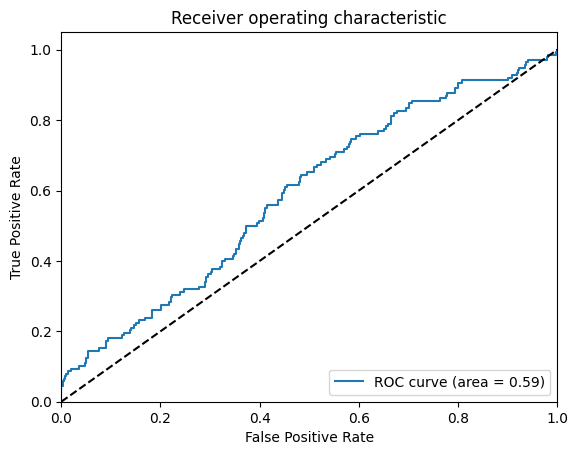

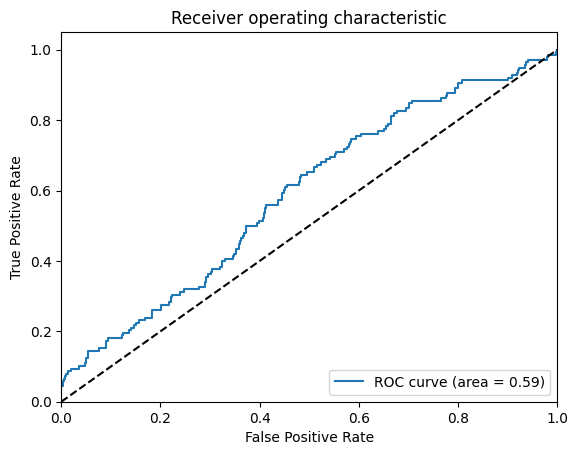

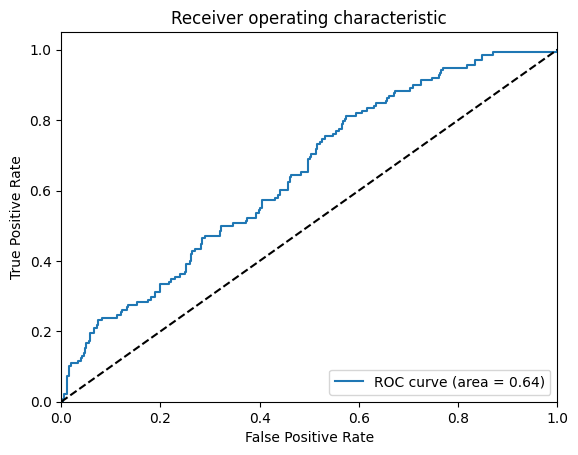

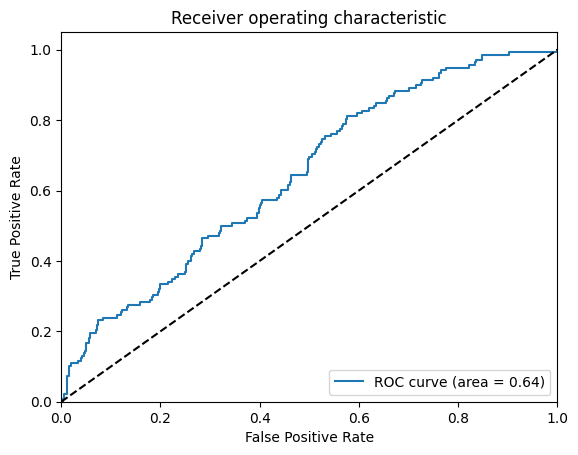

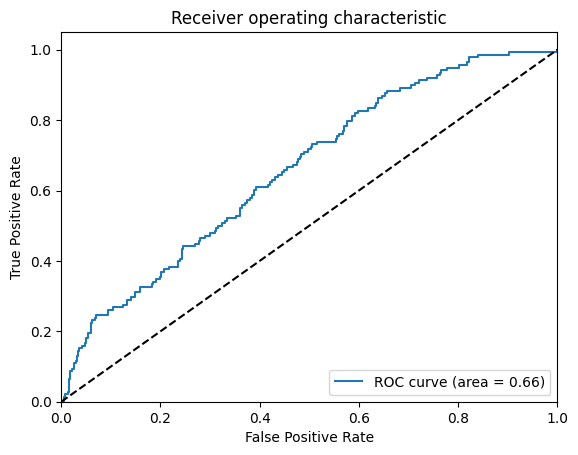

In [17]:
g# You may run this multiple times
# to try different learning rates eta and regularization parameters mu

train_data_path = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/data/train.svmlight'
test_data_path = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/data/test.svmlight'

model_folder = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/models'
result_folder = '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/results'

os.makedirs(model_folder, exist_ok=True)
os.makedirs(result_folder, exist_ok=True)

#eta = 0.01 # Learning rate
#mu = 0.0 # Regularization parameter
for eta, mu in [(0.01,0.0),(0.01,1e-4),(0.05,0.0),(0.05,1e-4),(0.10,1e-4)]:

  model_path = os.path.join(model_folder, f'model_eta{eta}_mu{mu}.pkl')
  result_path = os.path.join(result_folder, f'roc_eta{eta}_mu{mu}.png')

# Train the model
  classifier = train_script(train_data_path, eta, mu, n_feature, model_path)

# Evaluate the model
  test_script(test_data_path, model_path, result_path)

#### After finish drawing, run here to download all the ROC curve images

In [18]:
import shutil
from google.colab import files

shutil.make_archive('/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/results', 'zip', '/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/results')
files.download('/content/gdrive/MyDrive/bdh-hw2-pyspark-publish_colab/results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>